## 笔试《一》
## 使用tensorflow创建CNN对fashion-mnist数据集标签进行预测


In [1]:
from utils import mnist_reader
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

# 使用Github项目包含的函数读取数据
X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

1.4.0


### fashion-mnist数据集有10种类别，展示属于10个label中的一些图片

In [2]:
# 创建关于10种标签类别的dict
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

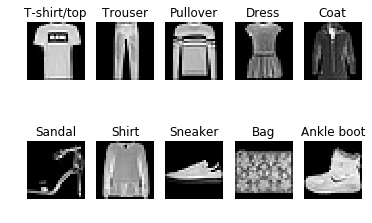

In [3]:
# 展示10种类别中的一件商品的图片
fig, axs = plt.subplots(2, 5)
images = []
for n in range(10):
    pic_index = np.argwhere(y_train == n)[0]
    images.append(axs[n//5,n%5])
    images[n].imshow(X_train[pic_index].reshape(28,28), cmap=plt.cm.gray)
    images[n].set_title(label_dict[n])
    images[n].axis('off')

plt.show()

### 数据预处理
对图像数据进行归一化处理，提高训练表现。提取train数据中的前5000作为validation set用于训练使用，对train、validation和test集的标签做one-hot encoding便于训练。把扁平化的单列图片数组信息重整为tensorflow接受的(n, width, height, channel)形状。

In [4]:
from tensorflow.python.keras.utils import to_categorical

# 归一化数据
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# 提取前5000为validation
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

# 设置tensor形状
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# one-hot encoding标签
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)


In [5]:
# 打印出特征和标签的数据信息形状
print('训练数据特征集大小为{}，训练数据标签集大小为{}'.format(X_train.shape, y_train.shape))
print('验证数据特征集大小为{}，验证数据标签集大小为{}'.format(X_valid.shape, y_valid.shape))
print('测试数据特征集大小为{}，测试数据标签集大小为{}'.format(X_test.shape, y_test.shape))

训练数据特征集大小为(55000, 28, 28, 1)，训练数据标签集大小为(55000, 10)
验证数据特征集大小为(5000, 28, 28, 1)，验证数据标签集大小为(5000, 10)
测试数据特征集大小为(10000, 28, 28, 1)，测试数据标签集大小为(10000, 10)


In [6]:
# 使用tensorflow的高级API keras包含的CNN网络模块做快速开发
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.python.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.python.keras.models import Sequential

# 设置序列模型
model = Sequential()

# 第一个卷积层，使用64个3x3的卷积核，same padding，最大池化层，BA层，Relu激活函数和20%的dropout
model.add(Conv2D(filters=64, kernel_size=[3, 3], input_shape=[28, 28, 1], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 第一个卷积层，使用128个3x3的卷积核，same padding，最大池化层，BA层，Relu激活函数和20%的dropout
model.add(Conv2D(filters=128, kernel_size=[3, 3], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 第一个卷积层，使用256个3x3的卷积核，same padding，最大池化层，BA层，Relu激活函数和20%的dropout
model.add(Conv2D(filters=256, kernel_size=[3, 3], padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

# 添加扁平层
model.add(Flatten())

# 添加全连接层
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# 最后一层输出对10种标签的预测，使用softmax激活函数
model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
__________

In [7]:
# 使用nadam梯度下降优化，交叉熵为损失函数，准确率为评估方法
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

# 设置100个epoch，100的batch size
epochs = 100
batch_size = 100

# 保留最佳模型
checkpointer = ModelCheckpoint(filepath = 'saved_models/weights.best.from_scratch.hdf5', 
                               verbose = 1, save_best_only = True)
# 训练模型
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid), 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=[checkpointer], 
          verbose=1)


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 15s - loss: 0.5987 - acc: 0.7961 - val_loss: 0.3809 - val_acc: 0.8686
Epoch 2/100
55000/55000 [==============================] - 11s - loss: 0.3678 - acc: 0.8700 - val_loss: 0.2755 - val_acc: 0.8976
Epoch 3/100
55000/55000 [==============================] - 11s - loss: 0.3196 - acc: 0.8877 - val_loss: 0.2919 - val_acc: 0.8860
Epoch 4/100
55000/55000 [==============================] - 11s - loss: 0.2920 - acc: 0.8970 - val_loss: 0.2508 - val_acc: 0.9118
Epoch 5/100
55000/55000 [==============================] - 11s - loss: 0.2700 - acc: 0.9036 - val_loss: 0.3553 - val_acc: 0.8758
Epoch 6/100
55000/55000 [==============================] - 11s - loss: 0.2606 - acc: 0.9077 - val_loss: 0.2406 - val_acc: 0.9112
Epoch 7/100
55000/55000 [==============================] - 11s - loss: 0.2431 - acc: 0.9147 - val_loss: 0.2205 - val_acc: 0.9188
Epoch 8/100
55000/55000 [=======================

55000/55000 [==============================] - 11s - loss: 0.1011 - acc: 0.9664 - val_loss: 0.2162 - val_acc: 0.9354
Epoch 63/100
55000/55000 [==============================] - 11s - loss: 0.0969 - acc: 0.9664 - val_loss: 0.2799 - val_acc: 0.9274
Epoch 64/100
55000/55000 [==============================] - 11s - loss: 0.0999 - acc: 0.9666 - val_loss: 0.2347 - val_acc: 0.9310
Epoch 65/100
55000/55000 [==============================] - 11s - loss: 0.0945 - acc: 0.9680 - val_loss: 0.2320 - val_acc: 0.9290
Epoch 66/100
55000/55000 [==============================] - 11s - loss: 0.1007 - acc: 0.9670 - val_loss: 0.2268 - val_acc: 0.9374
Epoch 67/100
55000/55000 [==============================] - 11s - loss: 0.0949 - acc: 0.9686 - val_loss: 0.2268 - val_acc: 0.9370
Epoch 68/100
55000/55000 [==============================] - 11s - loss: 0.0903 - acc: 0.9697 - val_loss: 0.2303 - val_acc: 0.9368
Epoch 69/100
55000/55000 [==============================] - 11s - loss: 0.0912 - acc: 0.9700 - val_loss

55000/55000 [==============================] - 10s - loss: 0.0821 - acc: 0.9729 - val_loss: 0.2590 - val_acc: 0.9304
Epoch 95/100
55000/55000 [==============================] - 11s - loss: 0.0799 - acc: 0.9745 - val_loss: 0.2264 - val_acc: 0.9330
Epoch 96/100
55000/55000 [==============================] - 11s - loss: 0.0851 - acc: 0.9722 - val_loss: 0.2275 - val_acc: 0.9358
Epoch 97/100
55000/55000 [==============================] - 11s - loss: 0.0784 - acc: 0.9735 - val_loss: 0.2440 - val_acc: 0.9384
Epoch 98/100
55000/55000 [==============================] - 11s - loss: 0.0820 - acc: 0.9742 - val_loss: 0.2553 - val_acc: 0.9324
Epoch 99/100
55000/55000 [==============================] - 11s - loss: 0.0820 - acc: 0.9745 - val_loss: 0.2758 - val_acc: 0.9266
Epoch 100/100
55000/55000 [==============================] - 11s - loss: 0.0813 - acc: 0.9746 - val_loss: 0.2469 - val_acc: 0.9364


In [12]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

# fashion_predict = [np.argmax(model.predict(np.expand_dims(img, axis=0))) for img in X_test]

# test_accuracy = 100 * np.sum(np.array(fashion_predict) == np.argmax(y_test, axis=1))/len(fashion_predict)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('训练的CNN模型测试集损失为{:4}，测试集准确率为{:4}%'.format(loss, accuracy*100))

测试集损失为0.22500082306861877，测试集准确率为92.11%


### 展示模型分类错误的前20个图像

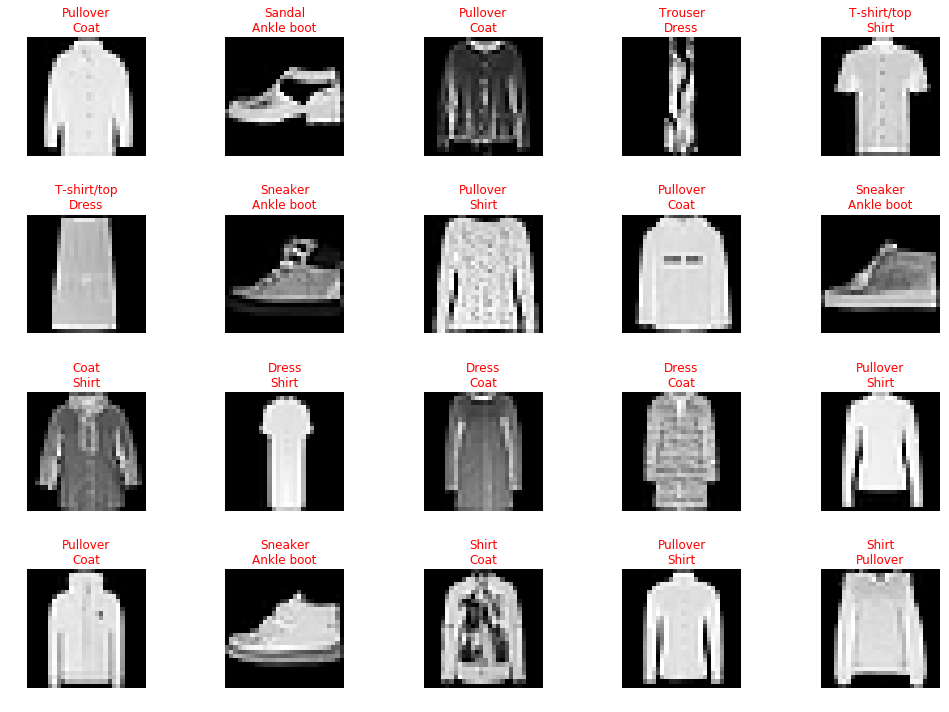

In [31]:
n_index = 0
miss_classified = []

# 记录前20个分类错误的项目
while len(miss_classified) < 20:
    predicted = np.argmax(model.predict(np.expand_dims(X_test[n_index], axis=0)))
    actual = np.argmax(y_test[n_index])
    if predicted != actual:
        miss_classified.append((n_index, predicted, actual))
    
    n_index +=1

# 展示错误分类的图片
fig, axs = plt.subplots(4, 5)
images = []
for n in range(20):
    pic_index = miss_classified[n]
    images.append(axs[n//5,n%5])
    images[n].imshow(X_test[pic_index[0]].reshape(28,28), cmap=plt.cm.gray)
    images[n].set_title('{}\n{}'.format(label_dict[pic_index[1]], 
                        label_dict[pic_index[2]]), color='r')
    images[n].axis('off')

fig.set_size_inches(14, 10, forward=True)
fig.tight_layout()
plt.show()

通过对一些错误分类的展示可以看出模型对数据集图片细节的学习还有待提升，一些相似的商品被错误分类了，如比较相似的套衫和外套，运动鞋和短靴等等。

## 笔试《二》
## 商家对用户针对性营销

拥有的数据：  
1. 商家名单。
2. 用户（亿级）数据-过去半年的所有行为数据，每个买家在每个商品上的浏览、收藏、推荐和购买数量。  
  
|用户/商品浏览（亿级）|商品1|商品2|。。。|商品n|
|-|-|-|-|-|
|用户1|O|X|。。。|X|
|用户2|O|O|。。。|O|
|。。。|。。。|。。。|。。。|。。。|
|用户m|X|O|。。。|X|

|用户/商品收藏（亿级）|商品1|商品2|。。。|商品n|
|-|-|-|-|-|
|用户1|O|X|。。。|X|
|用户2|O|O|。。。|O|
|。。。|。。。|。。。|。。。|。。。|
|用户m|X|O|。。。|X|

|用户/商品推荐（亿级）|商品1|商品2|。。。|商品n|
|-|-|-|-|-|
|用户1|O|X|。。。|X|
|用户2|O|O|。。。|O|
|。。。|。。。|。。。|。。。|。。。|
|用户m|X|O|。。。|X|

|用户/商品购买（亿级）|商品1|商品2|。。。|商品n|
|-|-|-|-|-|
|用户1|O|X|。。。|X|
|用户2|O|O|。。。|O|
|。。。|。。。|。。。|。。。|。。。|
|用户m|X|O|。。。|X|


### 1. 问题分析
我们的问题是根据过往**历史数据**训练模型能够帮助头部商户（一部分商户）有效地、有针对性地对客户进行营销，期望取得营利最大化。也就是帮助商户寻找潜在的、能够在店铺创造最大价值的客户。  
- 在商家端：希望接收到对自己商品最有兴趣、最有可能消费的客户群体。  
- 那么在用户的角度：需要挖掘用户潜在的、最可能购买的商品目录，在得到商品目录后，对目标商品的商家/商家群体推荐用户。  
  
### 2. 目标设定
所以这个推荐系统的目标是**根据历史数据，挖掘用户在接下来的时间，最想购买的商品/商品类目，再针对销售这些商品的商家推荐这些用户**。  
  
这个方案从两个方向：基于内容和协同性过滤讨论推荐系统。
### 3. 模型分析
#### 显性、隐性数据整合    
针对已有的用户行为数据类别，有一些**显性**的表述了用户对商品的偏好，比如用户的推荐和购买。而另一些只是**隐性**的指示了用户潜在的偏好或者购买意向，比如用户的商品浏览和收藏。在实际场景中，显性数据比隐性数据更稀疏，因为用户用心写评价和购买商品的行为比浏览和收藏少得多。所以推荐系统应该能够充分地挖掘不只是显性数据，更多是隐性数据的内在信息。  
  
所以需要对当前的4种用户行为进行权重整合，综合每一个用户对每一件商品的浏览、收藏、推荐和购买数量，分别加权，最终得出一个综合的用户对商品的偏好程度。那么目前的数据集就由4份变为1份：  

|用户/商品偏好|商品1|商品2|。。。|商品n|
|-|-|-|-|-|
|用户1|O|P12|。。。|P1n|
|用户2|O|O|。。。|O|
|。。。|。。。|。。。|。。。|。。。|
|用户m|Pm1|O|。。。|Pmn|  

### 4. 数据筛选
有一个数据维度的问题是：对于像淘宝这样庞大的电商网络，积累的数据是及其庞大的，用户数量可能在亿级，商品数量可能在几亿级。针对这样庞大的数据，以现有硬件水平是无法进行有效的复杂的矩阵运算、模型参数训练等等。所以数据降维是必要的。另一方面，现有的用户和商家数据可能是需要过滤的，比如说根据用户活跃度、商家的销售额进行过滤，提取更有价值的数据。 

### 5. 基于商品的推荐（content-based recommendation)
#### (1) 数据降维
通常来说，各个商品的类别已经被电商网络分类了，比如服饰类、电子产品类、食品、用品等等、又或是更加细分的类别、比如说电子产品类的电视、手机、笔记本电脑等等。假设共有1000种细分类别，那么针对这1000种类别商品的销售行为对具体商家进行聚类。  

在聚类之前需要先对特征量进行降维，使用像是PCA主成分分析等降维算法把现有细分商品的销售行为降至比如说100个维度，使用这100个维度从大体上表述商家。像是电子产品类、或是生活类的、或是大-中-小型的。。。等等的商家。可以使用PCA的每一个维度的解释方差比（explained variance ratio）来判断主成分对于原始数据的表达。
#### (2 商家聚类
在提取出销售行为类别（100个主成分）后，对商家进行聚类。假设商家分布大致拥有高斯分布，那么可以使用在超球形聚类下表现比较好的高斯混合模型（GMM）进行聚类，同时GMM也可以得到具体主成分在各个聚类中的归属概率。假设现已得到商家的类别大概有20个。
#### (3 商家的用户推荐
在得到商家的分类后，再计算出同一个聚类中商家的相似性（similarity），基于已有的用户偏好矩阵，预测用户对商家聚类的偏好程度，把用户的偏好商家从高到低排列，**继而可以向改用户偏好程度高的商家聚类中的全部或是一些商家推荐这个用户。**

|用户/商家类别偏好|商家类1|商家类2|。。。|商家类20|
|-|-|-|-|-|
|用户1|0.1|0.1|。。。|0.6|
|用户2|0.2|0.5|。。。|0.3|
|。。。|。。。|。。。|。。。|。。。|
|用户m|0.1|0.3|。。。|0.5|

### 6. 基于协同性过滤的推荐模型（collaborative filtering methods）
协同性过滤不依赖于商品的特征，而是根据用户之间潜在的关联性进行相互的推荐。这种方式可以帮助用户发掘之前没有了解过的新的兴趣。
#### (1) 矩阵分解
矩阵分解是一种数据降维的方法，把用户的**偏好矩阵**使用两个、或者多个拥有k个潜在属性的小型矩阵表达。
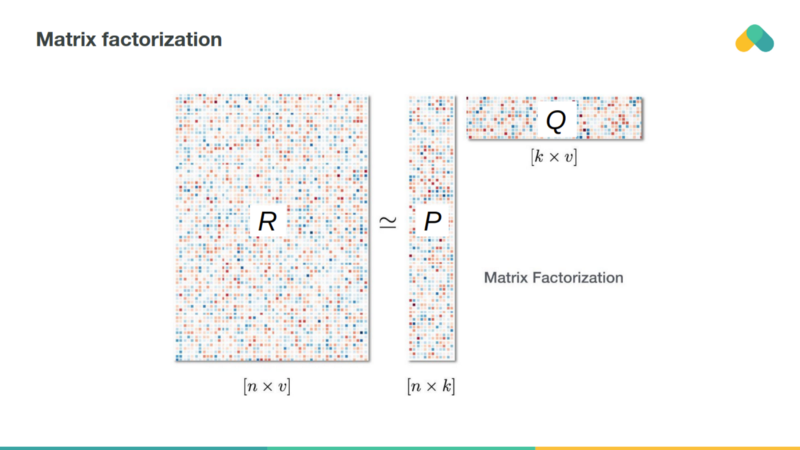

可以使用随机梯度下降做矩阵分解，根据损失函数来优化各个参数。得到矩阵分解后再将矩阵相乘，可以预测用户对商品的偏好。

#### (2) 使用机器学习方法
**可以在推荐系统中使用多种机器学习方法：**
- 可以训练基于商品数据和用户特征的神经网络来预测用户偏好。
- 可以基于用户行为的历史数据训练RNN网络预测用户的下一步行为。
- 可以构建基于图像类别的CNN网络对用户推荐图像上相似的商品。  

#### (3) Autoencoder
**使用深层神经网络学习商品数据**
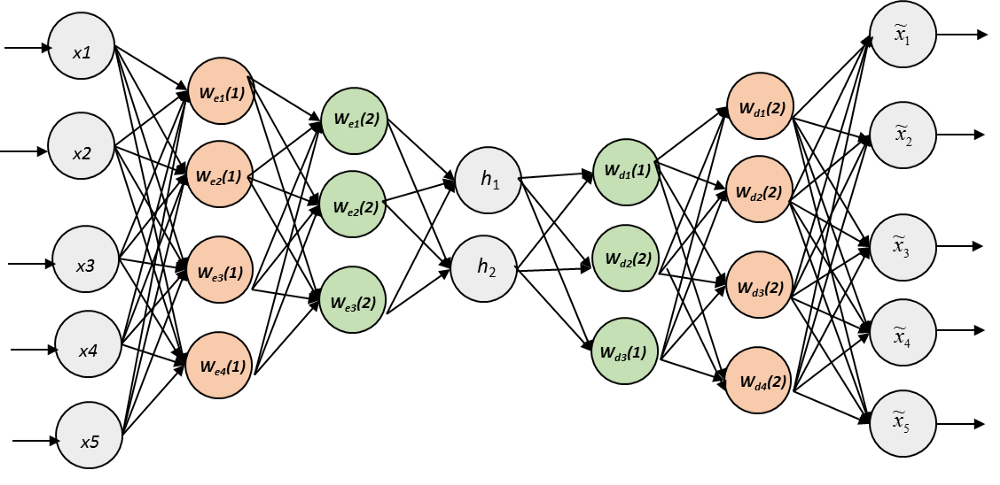

构建Autoencoder网络，构建等量的输入和输出层，在之间使用维度小很多的多层隐藏神经网络层连接。这样可以显著对商品数据集进行降维，通过隐藏层学习到对每一件商品潜在的属性以及关联。**通过同时训练Autoencoder和矩阵分解，可以即获得用户协同信息，同时也获得商品的关联信息。**  

#### (4) 使用CNN网络学习用户的类似喜好
许多类似的商品在风格上相似，比如各种罐装的饮料，滑板车，桌椅家具等等，淘宝拥有许多这样的高清晰度图片。那么可以**训练卷积神经网络对用户的历史行为进行图像分类，然后把最受欢迎的这个类别的商品进行推荐，应该可以得到比较好的效果。**  

使用商家的产品图片作为数据集，训练CNN图片分类器，得到多种商品的类别。再输入用户交互过的产品图片，得到风格信息，再对用户推荐同一类中的受欢迎产品。

#### (5) 使用循环神经网络对用户的行为序列进行预测
在拥有用户的历史数据后可以训练循环神经网络学习用户行为在时间上的潜在模式：
- 可以处理用户的历史数据，对用户将来一段时间的购买行为进行预测，比如购买了孕期用品的孕妇可能在一段时间后再度购买婴儿用品，具有周期性购买行为如日常生活用品、食品等等。
- 可以输入CNN网络中学习到的商品信息，对用户购买下一件或下几件图像类似的产品的序列进行预测。
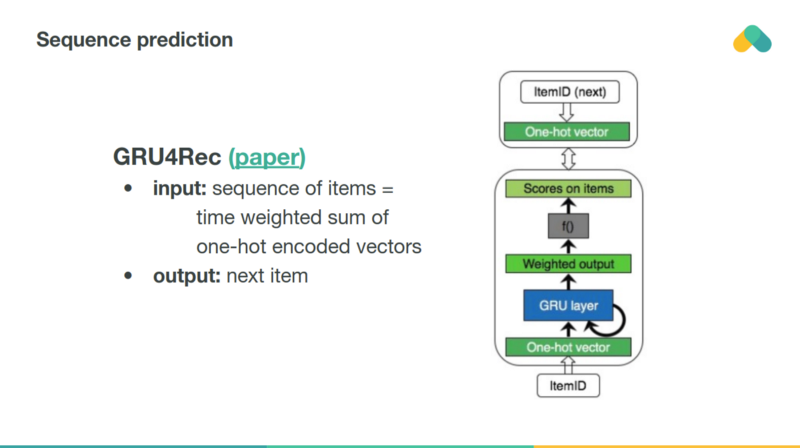
  
### 7. 模型评估
#### (1) 召回率
统计模型预测结果中：用户喜欢的产品中，有多少成功推荐了。tp表示用户喜欢并且推荐了、fn表示用户喜欢但模型没能推荐。
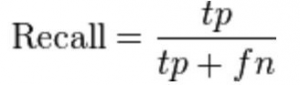
召回率越大，模型的推荐行为的包含度越好。
#### (2) 精准率
统计模型预测结果中：用户被推荐的产品中，有多少是用户喜欢的。fp表示模型推荐了但用户不喜欢。
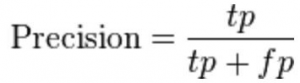
精准率越大，模型的推荐目标的精准度越好。
#### (3) 均方根误差 RMSE
衡量模型对用户偏好预测和真实数据的均方根误差。
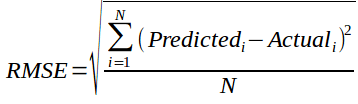
均方根误差越小，说明模型对用户喜好的掌握越好。
### 8. 用户行为预测系统集成
  
对多种方法、模型的集成可以得到更好的效果。组合多种模型构建层次化的用户预测系统，通过提高对用户口味的掌握、购买序列的预测、构建更完善的用户画像，可以综合地提高预测系统的表现，
### 总结

建立表现比较好的用户推荐系统后，可以在收集到比如说半年时间的用户历史活动后，对用户的偏好和用户可能的购买序列有比较好的了解。那么就可以在我们已有的头部商家信息中，有针对性地把偏好这些商家产品中的高价值用户群体推荐给他们。


### 我平时阅读的技术类书籍有：
- 编程语言类的《Fluent Python》《Python Cookbook》《C++ Primer》《Headfirst Java》
- 技术类的O'Reilly《OpenCV 3》《Twisted网络架构》，Ian Goodfellow《Deep Learning》等

### 我平时遇到技术问题时：
首先使用Google搜索查找，经常能够在像Stackoverflow这样的程序员问答网站找到类似问题的解决方法，或是在Github上相关项目的Issue找到解答或解决方案。  
对于常用的开源框架，官方的文档，指南和API是最好的查询场所，如果需要对一种技术有比较全面的了解，medium.com有很多高质量的博文，YouTube也能搜索到很多技术介绍视频。zh